In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_atac_cage_early as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_atac_cage_early as training_utils


from scipy import stats



2023-03-08 14:38:19.347206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:38:23.280535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 14:38:23.280577: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 14:38:32.509987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-8')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2023-03-07 14:57:43.421685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:57:43.445562: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:57:43.445643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2023-03-07 14:57:43.792989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:57:44.322843: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:447] Started server with target: grpc://localhost:38617
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: node-8


INFO:tensorflow:Initializing the TPU system: node-8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
#with strategy.scope():

model = aformer.aformer(kernel_transformation="relu_kernel_transformation",
                        dropout_rate=0.05,
                        pointwise_dropout_rate=0.15,
                        input_length=196608,
                        output_length=1536,
                        final_output_length=896,
                        num_heads=4,
                        numerical_stabilizer=0.0000001,
                        nb_random_features=256,
                        #hidden_size=wandb.config.hidden_size,
                        #d_model=wandb.config.hidden_size,
                        #dim=wandb.config.hidden_size // wandb.config.num_heads,
                        max_seq_length=1536,
                        rel_pos_bins=1536,
                        norm=True,
                        BN_momentum=0.90,
                        use_rot_emb = True,
                        use_mask_pos = False,
                        normalize = True,
                        predict_masked_atac_bool=True,
                        num_transformer_layers=6,
                        #inits=inits,
                        #inits_type="enformer_conv",
                        #load_init=True,
                        stable_variant=False,
                        freeze_conv_layers=False,
                        filter_list_seq=[768, 896, 1024, 1152, 1280, 1536],
                        filter_list_atac=[32,64],
                        learnable_PE=True,
                        global_acc_size=128)

test = tf.ones((1,196608,4)),tf.ones((1,49152,1)),tf.ones((1,1,1536))
model(test,training=False)
print('ran test input')
model.load_weights("gs://picard-testing-176520/paired_rampage_atac/genformer/models/aformer_baseline_GENFORMER_glob_acc-True_atac-True_mask-True_load-True_frz-False_LR1-5e-06_LR2-0.0001_T-6_D-0.05_2023-03-04_23:58:19/iteration_20/saved_model")
print('loaded weights')

def predict_on_batch(model, inputs):
    return model.predict_on_batch(inputs)

@tf.function
def contribution_input_grad(model, model_inputs, gradient_mask):
    seq, atac, tf_acc=model_inputs
    gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
    gradient_mask_mass = tf.reduce_sum(gradient_mask)

    with tf.GradientTape() as input_grad_tape:
        input_grad_tape.watch(seq)
        input_grad_tape.watch(atac)
        input_grad_tape.watch(tf_acc)
        inputs = seq,atac,tf_acc
        prediction, att_matrices = model.predict_on_batch(inputs)
        
        prediction = tf.cast(prediction,dtype=tf.float32)
        gradient_mask = tf.cast(gradient_mask,dtype=tf.float32)
        prediction_CAGE = tf.reduce_sum(gradient_mask *
                                        prediction) / gradient_mask_mass


    input_grads = input_grad_tape.gradient(prediction_CAGE, inputs)
    
    input_grads_seq = input_grads[0] 
    input_grads_atac = input_grads[1]
    input_grads_tf_acc = input_grads[2]

    seq_grads = tf.reduce_sum(input_grads_seq[0,:,:] * seq[0,:,:],
                              axis=1)

    atac_grads = input_grads_atac[0,:,] * atac[0,:,]

    tf_acc_grads = input_grads[2][0,:]

    return seq_grads, atac_grads, tf_acc_grads, prediction, att_matrices



/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


ran test input
loaded weights


In [4]:
def one_hot(sequence):
    '''
    convert input string tensor to one hot encoded
    will replace all N character with 0 0 0 0
    '''
    vocabulary = tf.constant(['A', 'C', 'G', 'T'])
    mapping = tf.constant([0, 1, 2, 3])

    init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                               values=mapping)
    table = tf.lookup.StaticHashTable(init, default_value=0)

    input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

    out = tf.one_hot(table.lookup(input_characters), 
                      depth = 4, 
                      dtype=tf.float32)
    return out


    
def deserialize_val_TSS(serialized_example,input_length,max_shift,output_length_ATAC,
                        output_length,crop_size,output_res,predict_masked_atac_bool,atac_mask_dropout, use_global_acc, use_atac, log_atac,g):
    """Deserialize bytes stored in TFRecordFile."""
    feature_map = {
        'sequence': tf.io.FixedLenFeature([], tf.string),
        'atac': tf.io.FixedLenFeature([], tf.string),
        'cage': tf.io.FixedLenFeature([], tf.string),
        'tss_tokens': tf.io.FixedLenFeature([], tf.string),
        'processed_gene_token': tf.io.FixedLenFeature([], tf.string),
        'cell_type': tf.io.FixedLenFeature([], tf.string),
        'cell_specific_conv_arr': tf.io.FixedLenFeature([], tf.string)
    }
    
    seq_shift = 5
    input_seq_length = input_length + max_shift

    ### rev_comp
    #rev_comp = random.randrange(0,2)

    data = tf.io.parse_example(serialized_example, feature_map)
    sequence = one_hot(tf.strings.substr(data['sequence'],
                                 seq_shift,input_length))
    
    
    #### parse ATAC and transform as specified
    atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                              out_type=tf.float32),
                           [output_length_ATAC,1])
    #diff = tf.math.sqrt(tf.nn.relu(atac - 64.0 * tf.ones(atac.shape)))
    #atac = tf.clip_by_value(atac, clip_value_min=0.0, clip_value_max=64.0) + diff
    
    
    if not use_atac:
        atac = tf.math.abs(g.normal(atac.shape,
                             mean=0.0,
                             stddev=0.00001,
                             dtype=tf.float32))
    if log_atac: 
        atac = tf.math.log1p(atac)
    
                           
    ### here we generate a masked output vector length since we are predicting at 1536
    atac_mask = tf.ones(output_length // 4,dtype=tf.float32)
    atac_mask=tf.nn.experimental.stateless_dropout(atac_mask, 
                                                     rate=(atac_mask_dropout), 
                                                     seed=[0,seq_shift]) / (1. / (1.0-(atac_mask_dropout)))

    atac_mask = tf.expand_dims(atac_mask,axis=1)
    atac_mask = tf.tile(atac_mask, [1,4])
    atac_mask = tf.reshape(atac_mask, [-1])
    atac_mask = tf.expand_dims(atac_mask,axis=1)

    atac_mask_store = 1.0 - atac_mask ## invert the mask, since we want to store which values were masked and loss should be computed over
    atac_mask_store = tf.slice(atac_mask_store,
                            [crop_size,0],
                            [output_length-2*crop_size,-1])
    tiling_req = output_length_ATAC // output_length
    atac_mask = tf.expand_dims(tf.reshape(tf.tile(atac_mask, [1,tiling_req]),[-1]),axis=1)
    
    masked_atac = atac * atac_mask
    
    cage = tf.ensure_shape(tf.io.parse_tensor(data['cage'],
                                              out_type=tf.float32),
                           [output_length - 2*crop_size,1])
    diff = tf.math.sqrt(tf.nn.relu(cage - 2000.0 * tf.ones(cage.shape)))
    cage = tf.clip_by_value(cage, clip_value_min=0.0, clip_value_max=2000.0) + diff
    cage = tf.cast(tf.cast(cage,dtype=tf.float16),dtype=tf.float32) ### round to be consistent with Enformer
    
    tss_tokens = tf.io.parse_tensor(data['tss_tokens'],
                                  out_type=tf.int32)
    tss_tokens = tf.expand_dims(tss_tokens,axis=1)
    tss_tokens = tss_tokens / tf.reduce_max(tss_tokens)

    gene_token= tf.io.parse_tensor(data['processed_gene_token'],
                                   out_type=tf.int32)

    cell_type = tf.io.parse_tensor(data['cell_type'],
                                  out_type=tf.int32)
    
    global_acc = tf.ensure_shape(tf.io.parse_tensor(data['cell_specific_conv_arr'],
                                              out_type=tf.float32),
                           [1536])
    global_acc=tf.expand_dims(global_acc,axis=0)
    global_acc = tf.math.asinh(global_acc)
    global_acc = (global_acc - tf.math.reduce_mean(global_acc)) / tf.math.reduce_std(global_acc)
    
    if not use_global_acc:
        global_acc = g.normal(global_acc.shape,
                              mean=0.0,
                              stddev=0.025,
                              dtype=tf.float32)

    if predict_masked_atac_bool:
        atac_out = tf.reduce_sum(tf.reshape(atac, [-1,tiling_req]),axis=1,keepdims=True)
        atac_out = tf.slice(atac_out,
                            [crop_size,0],
                            [output_length-2*crop_size,-1])
        target = tf.concat([atac_out,cage],axis=1)
    

    if predict_masked_atac_bool:
        return {'sequence': tf.ensure_shape(sequence,
                                            [input_length,4]),
                'atac': tf.ensure_shape(masked_atac,
                                          [output_length_ATAC,1]),
                'atac_mask': tf.ensure_shape(atac_mask_store,
                                          [output_length-crop_size*2,1]),
                'target': tf.ensure_shape(target,
                                          [output_length-crop_size*2,2]),
                'tss_tokens': tf.ensure_shape(tss_tokens,
                                          [output_length-2*crop_size,1]),
                'global_acc': tf.ensure_shape(global_acc,
                                          [1,1536]),
                'gene_token':gene_token,
                'cell_type': cell_type}
    else:
        return {'sequence': tf.ensure_shape(sequence,
                                            [input_length,4]),
                'atac': tf.ensure_shape(atac,
                                          [output_length_ATAC,1]),
                'target': tf.ensure_shape(cage,
                                          [output_length-crop_size*2,1]),
                'tss_tokens': tf.ensure_shape(tss_tokens,
                                          [output_length-2*crop_size,1]),
                'global_acc': tf.ensure_shape(global_acc,
                                          [1,1536]),
                'gene_token':gene_token,
                'cell_type': cell_type}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


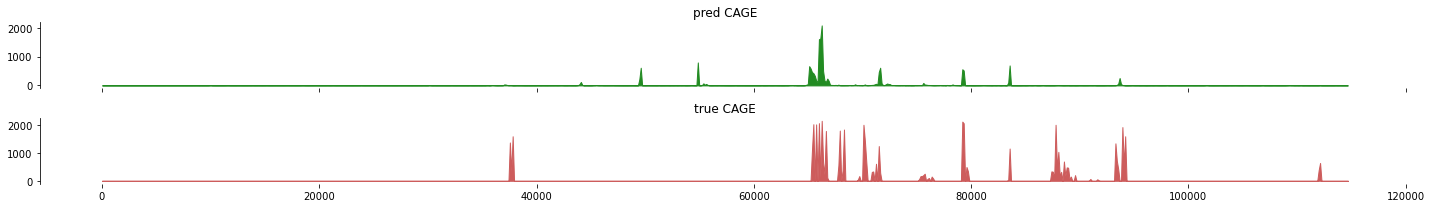

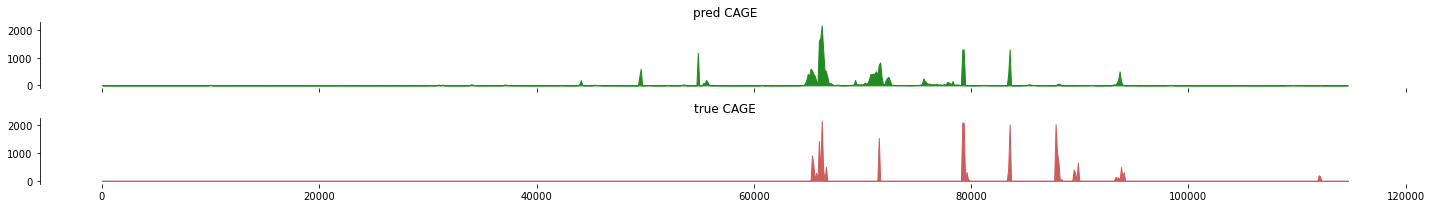

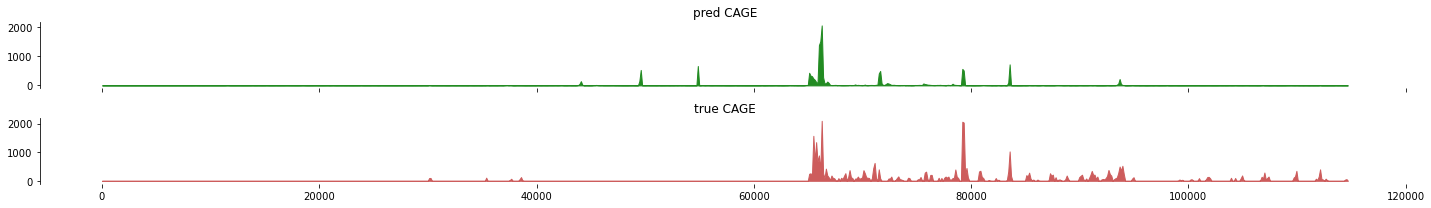

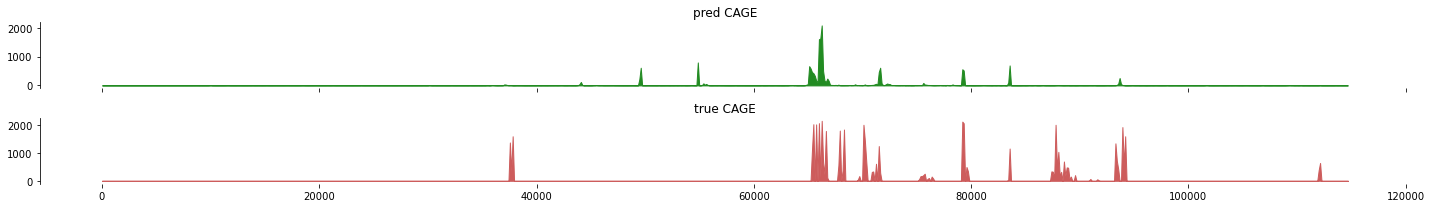

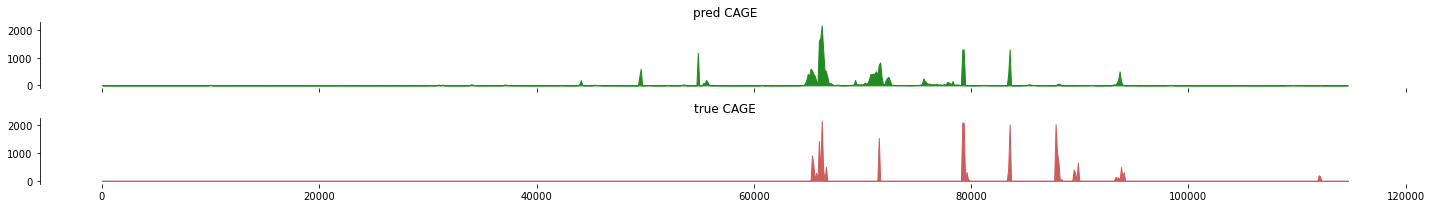

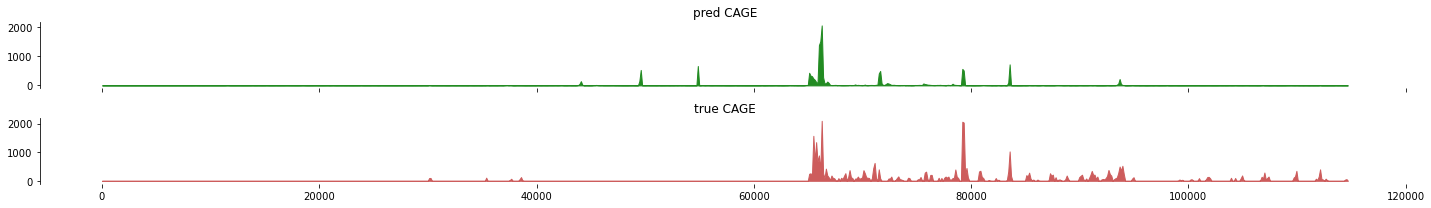

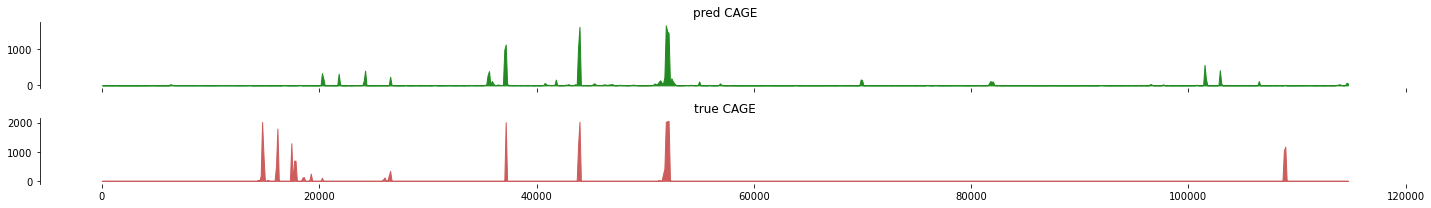

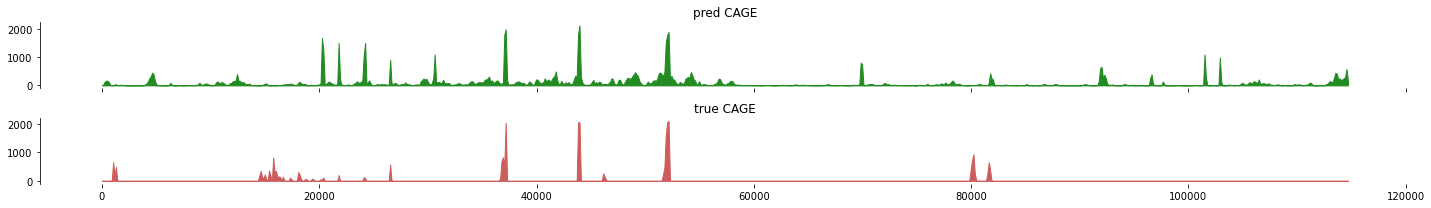

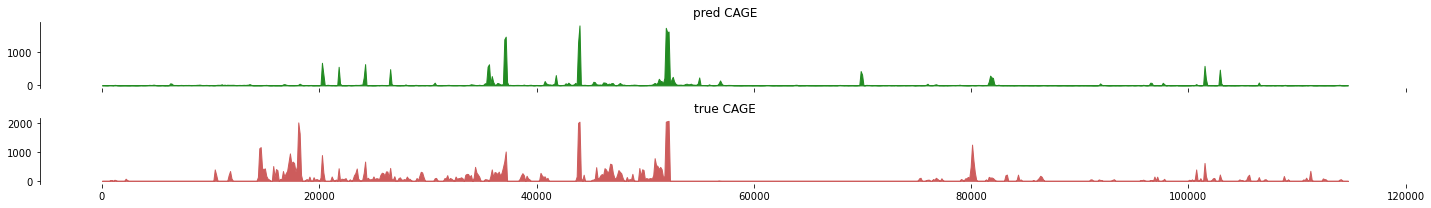

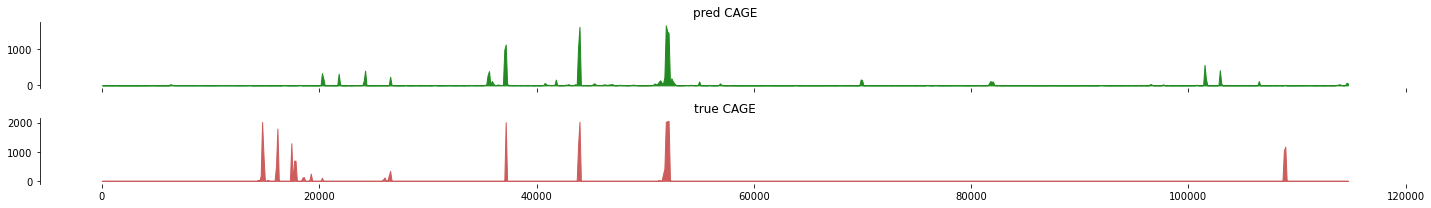

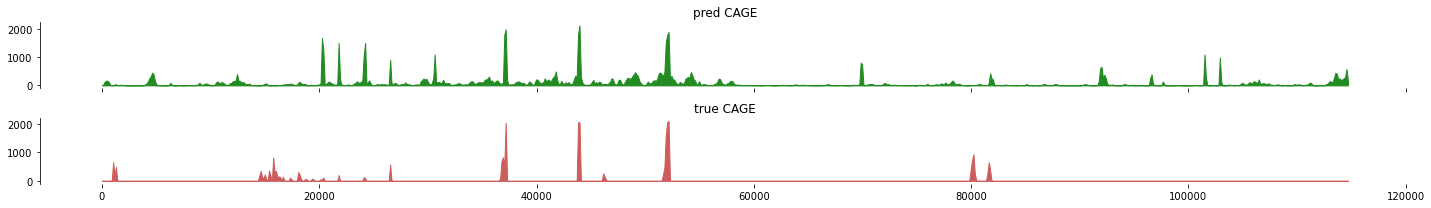

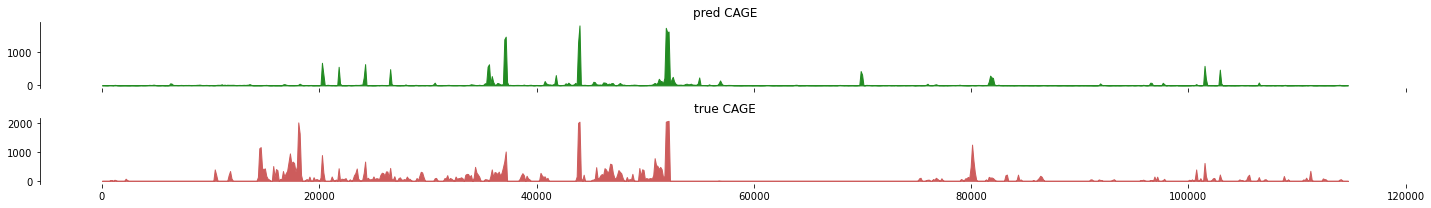

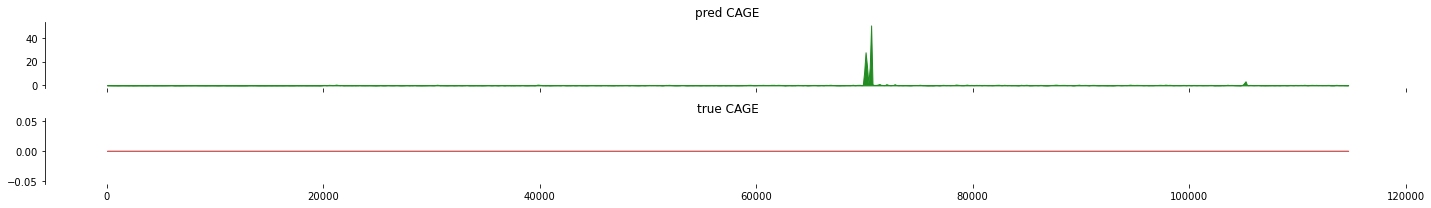

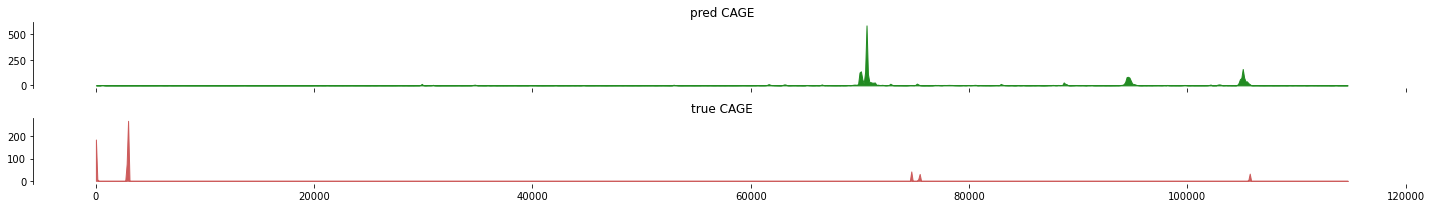

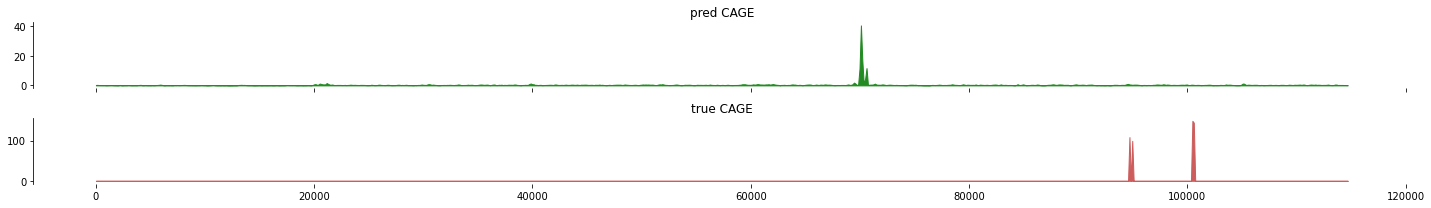

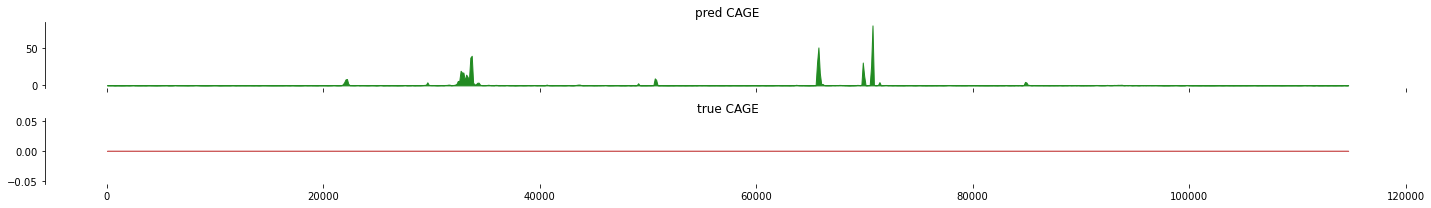

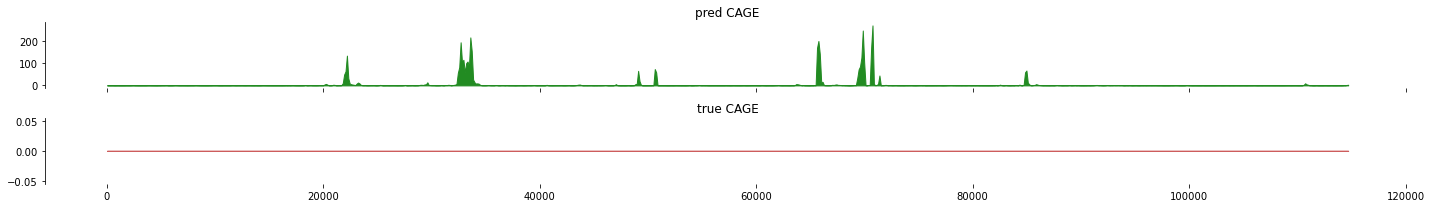

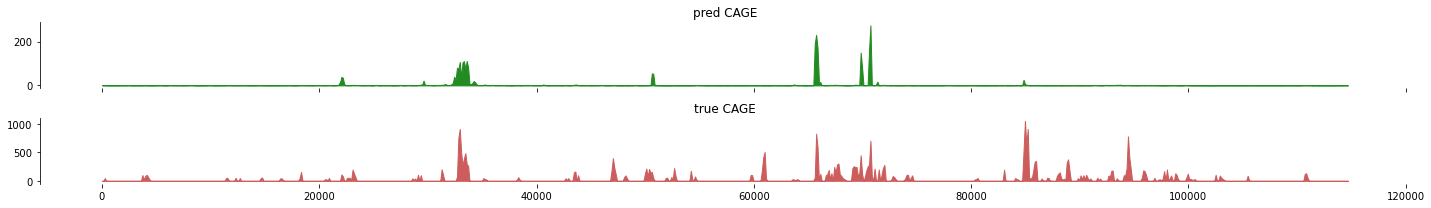

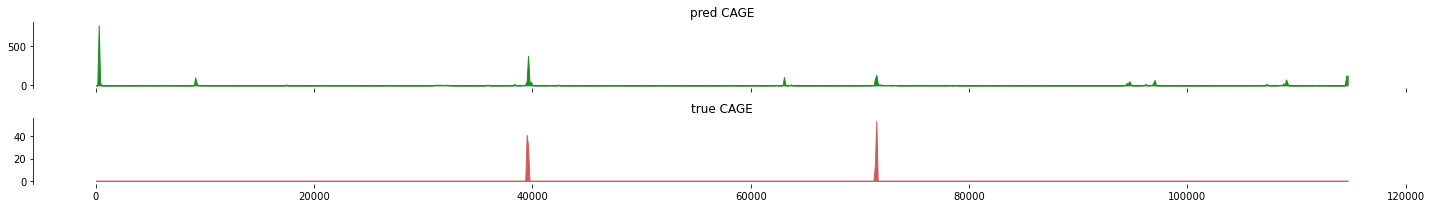

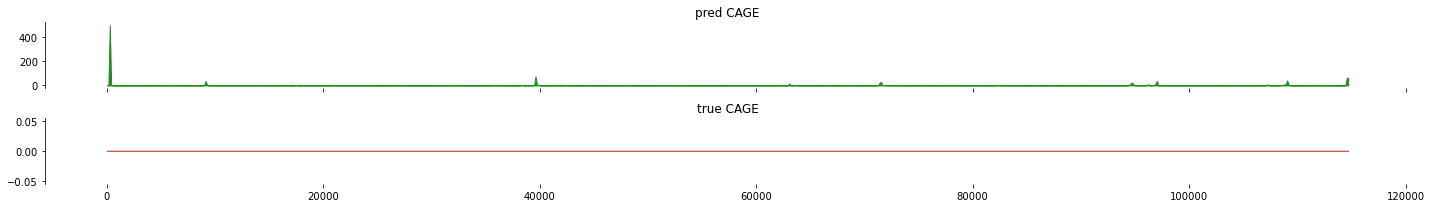

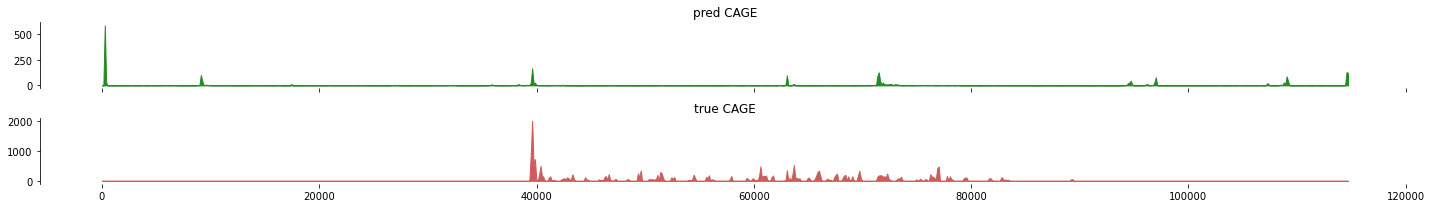

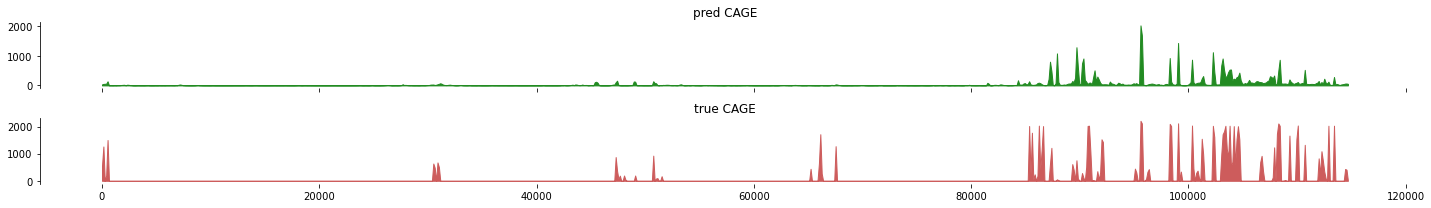

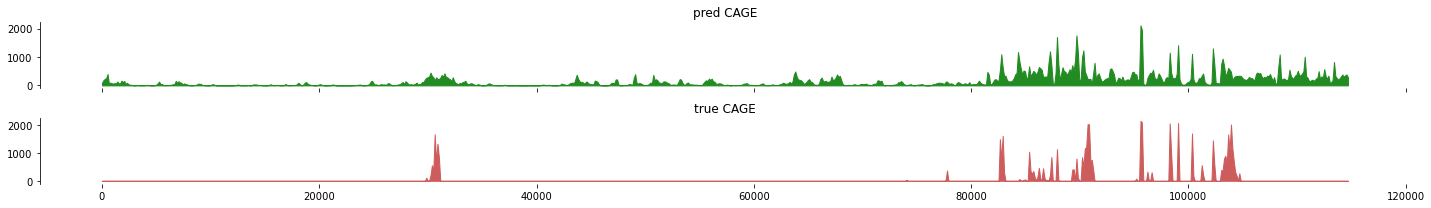

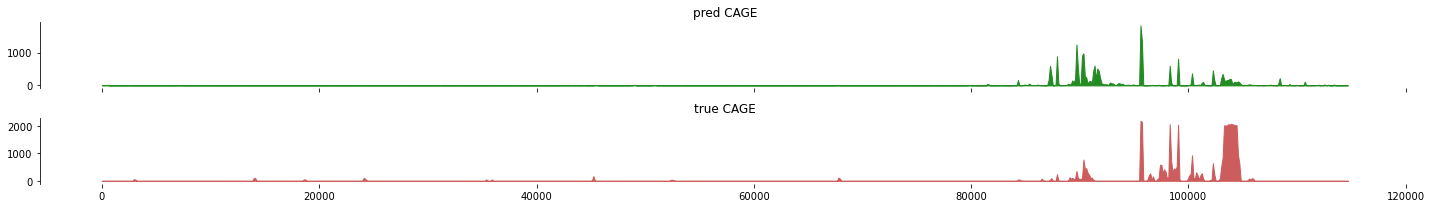

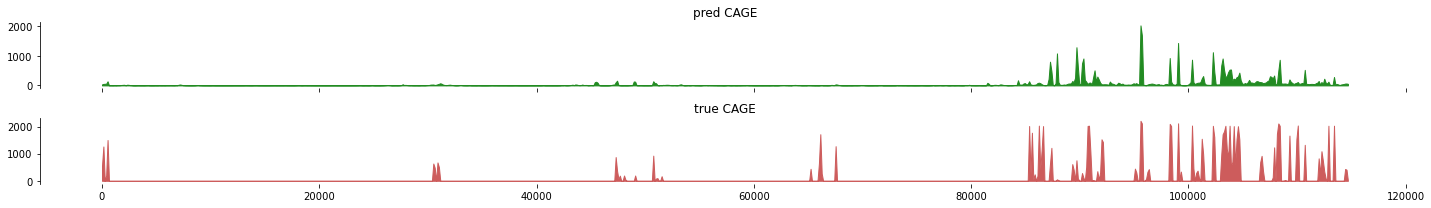

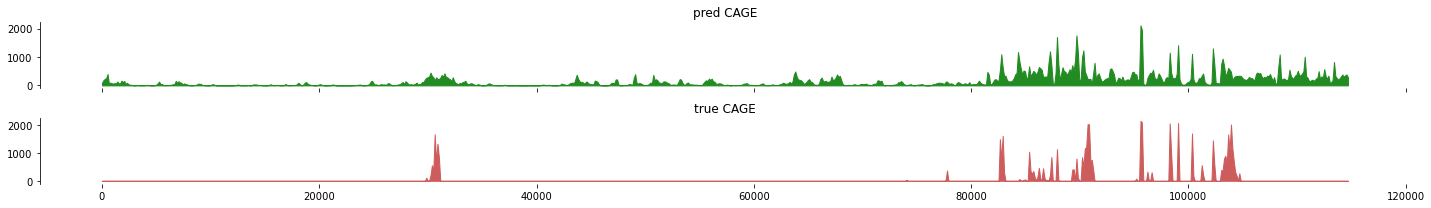

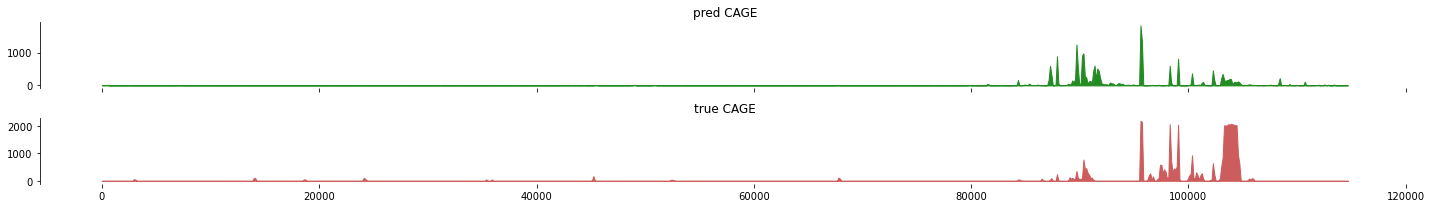

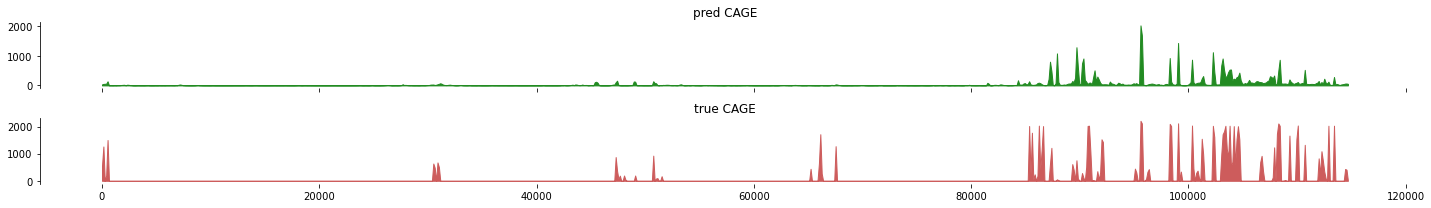

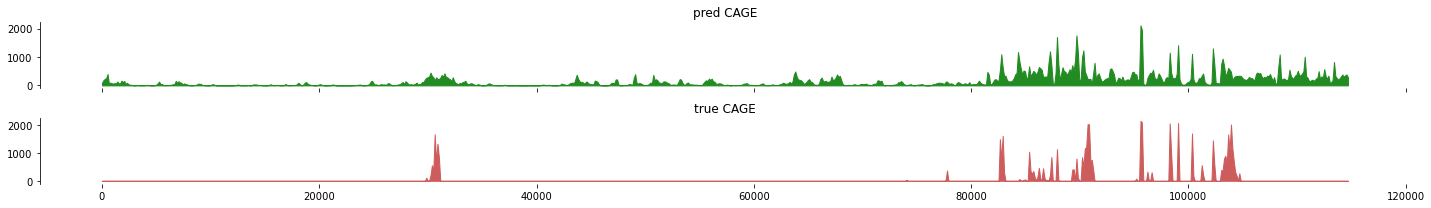

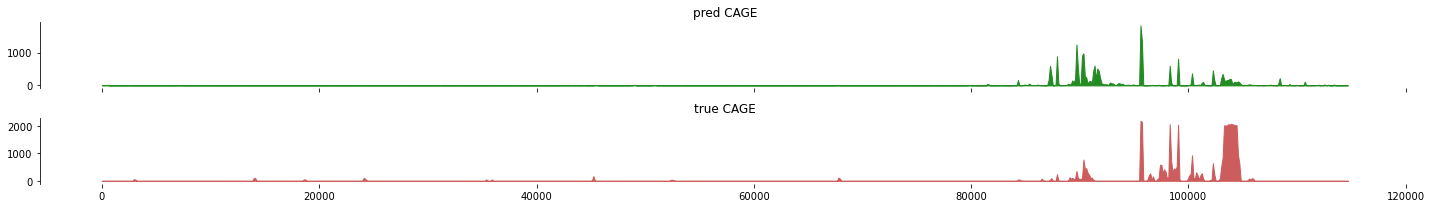

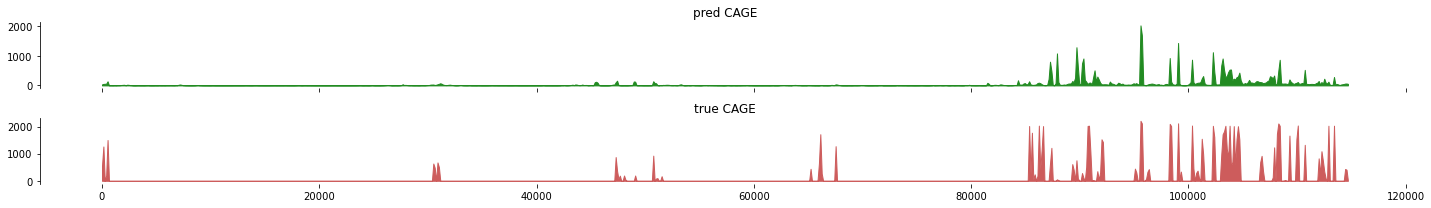

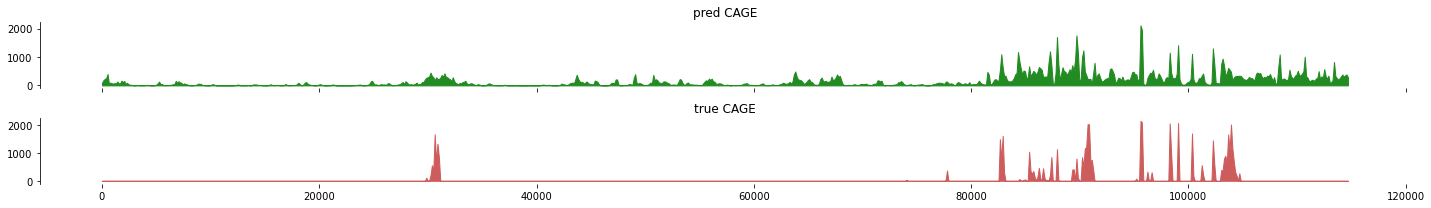

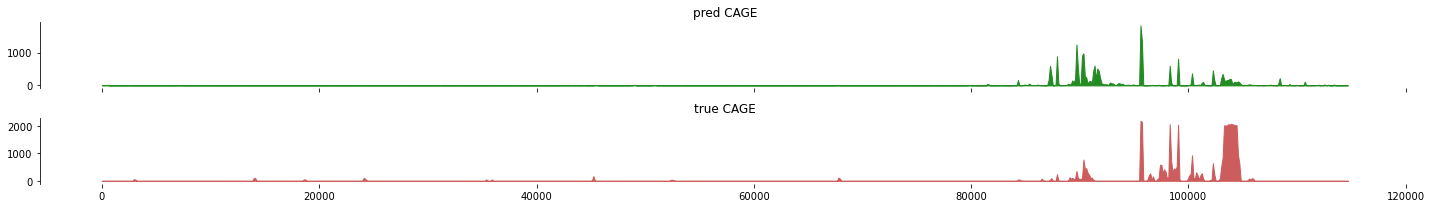

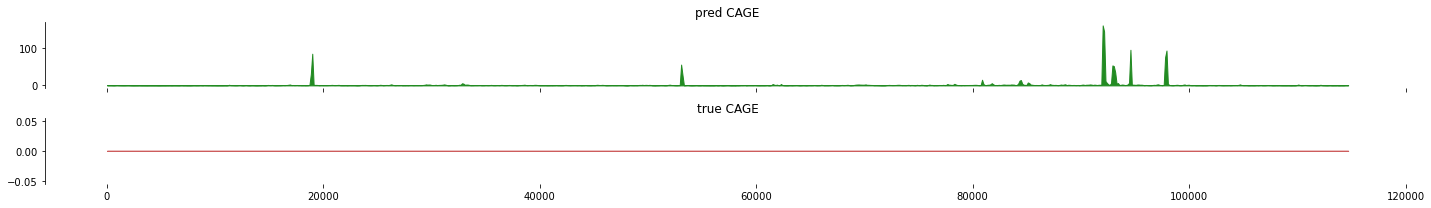

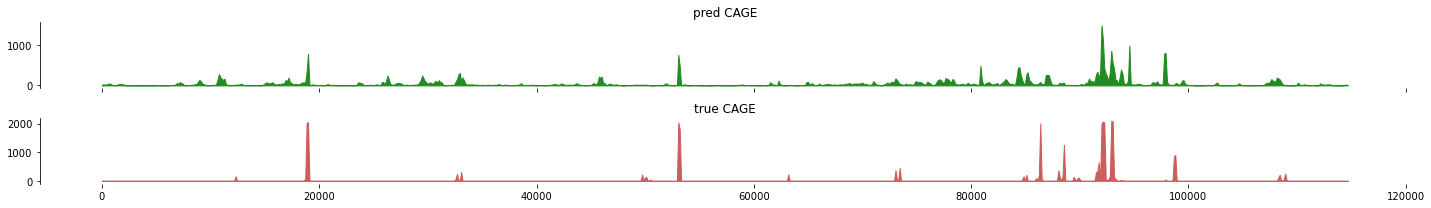

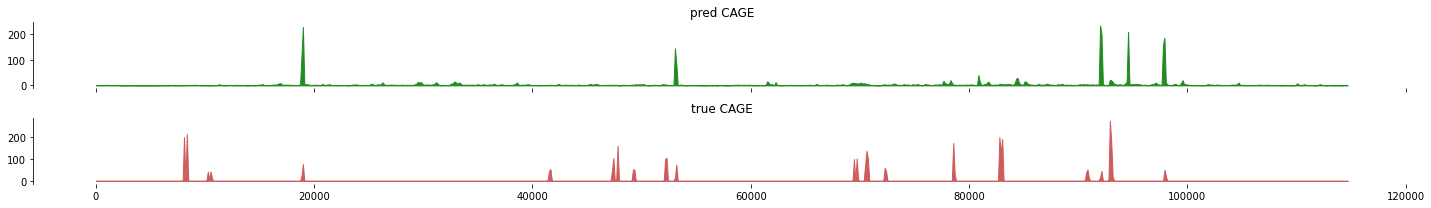

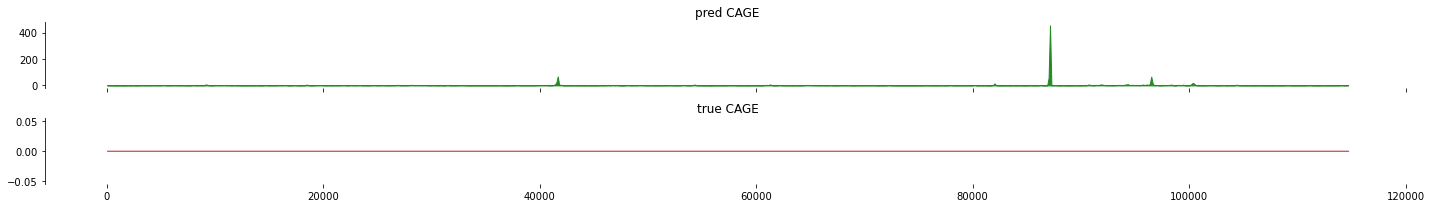

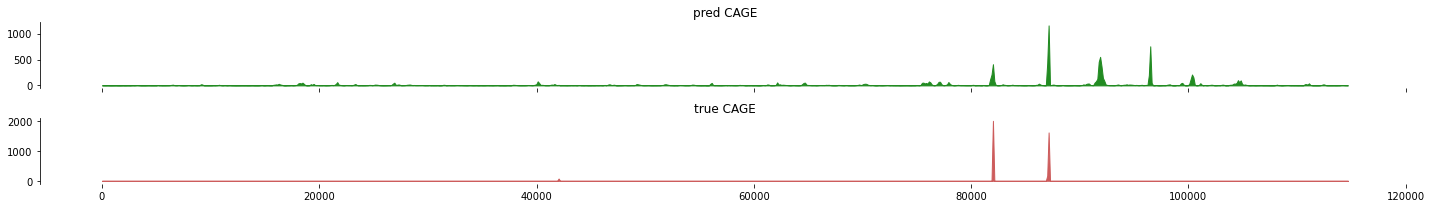

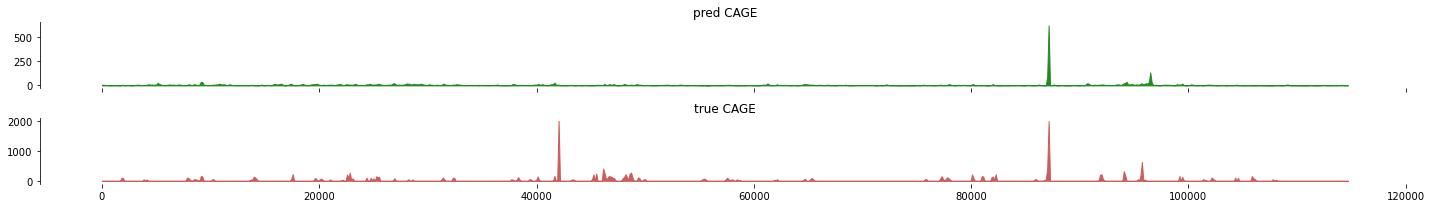

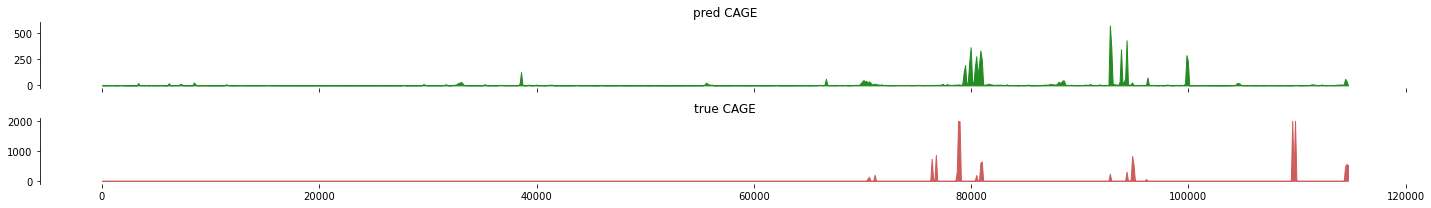

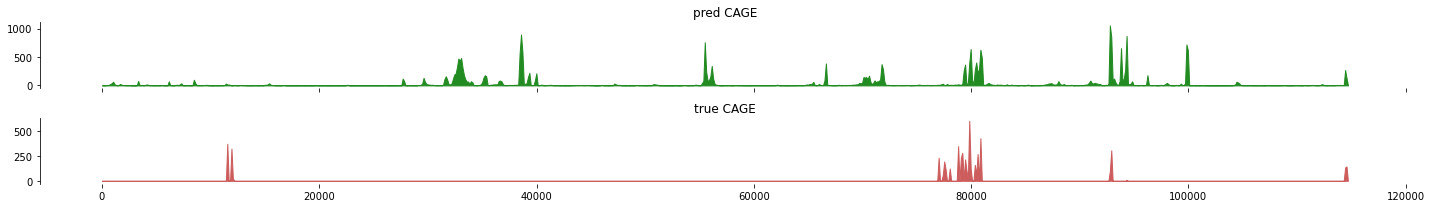

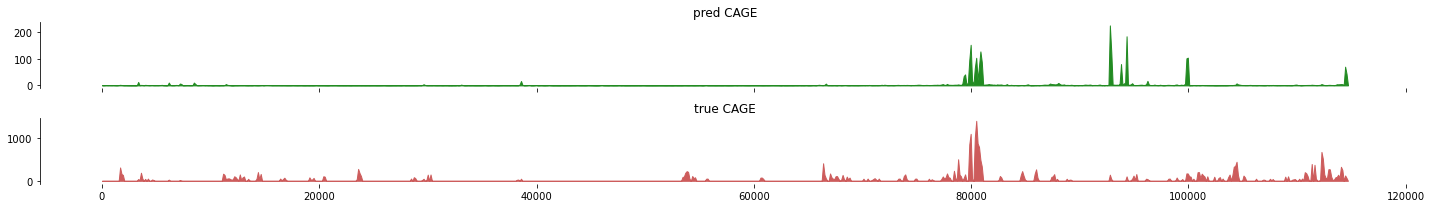

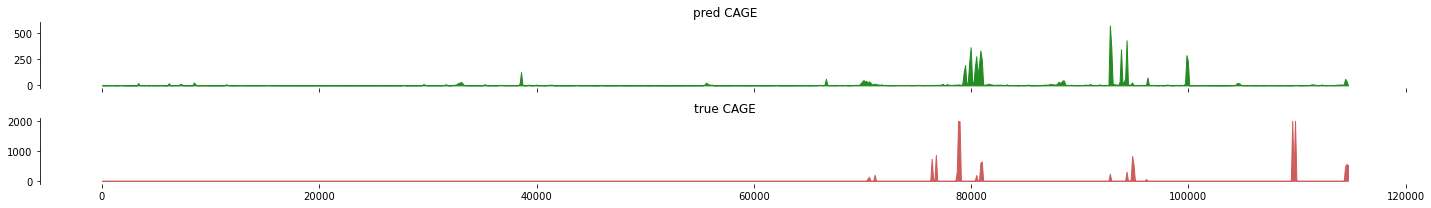

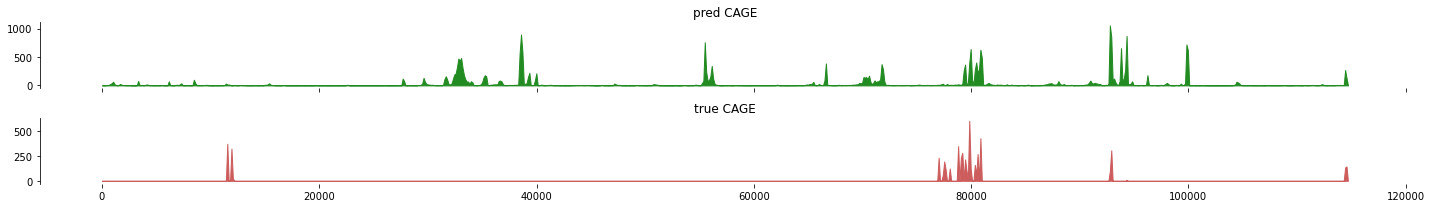

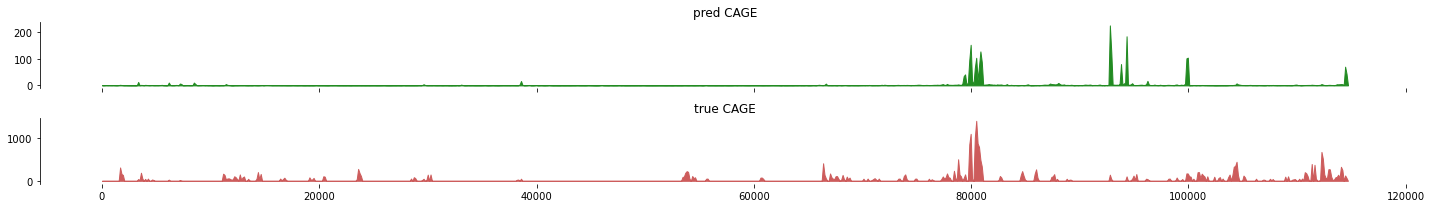

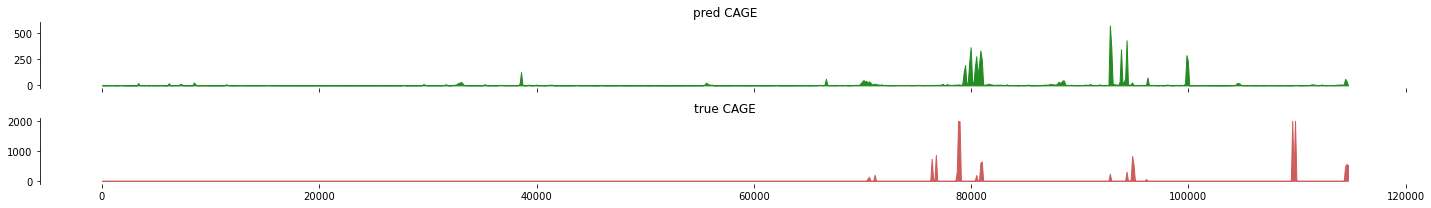

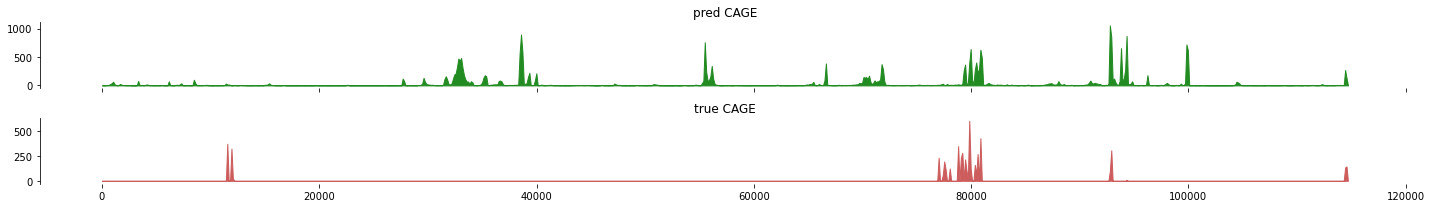

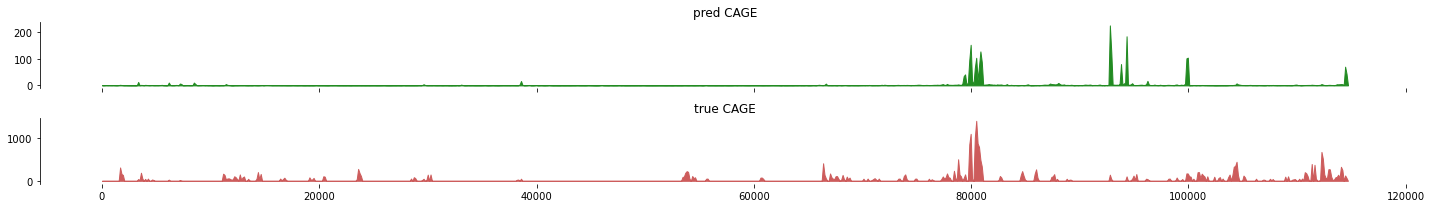

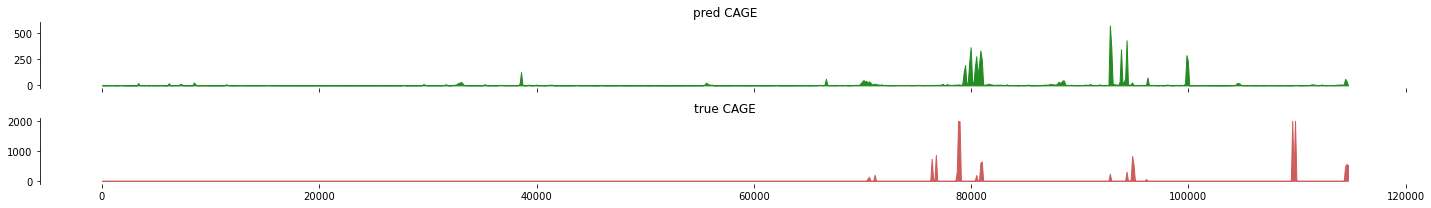

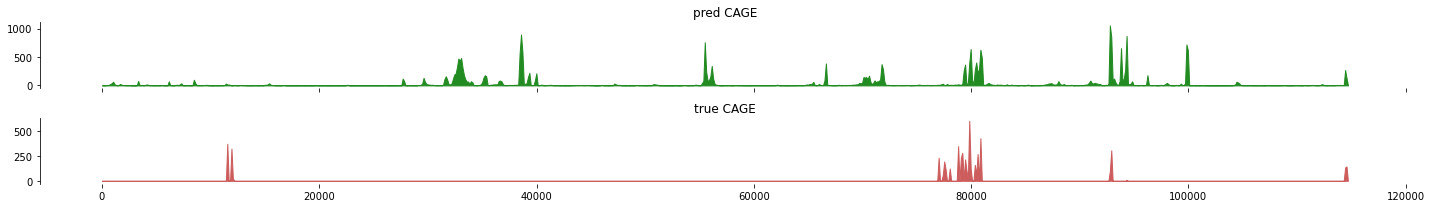

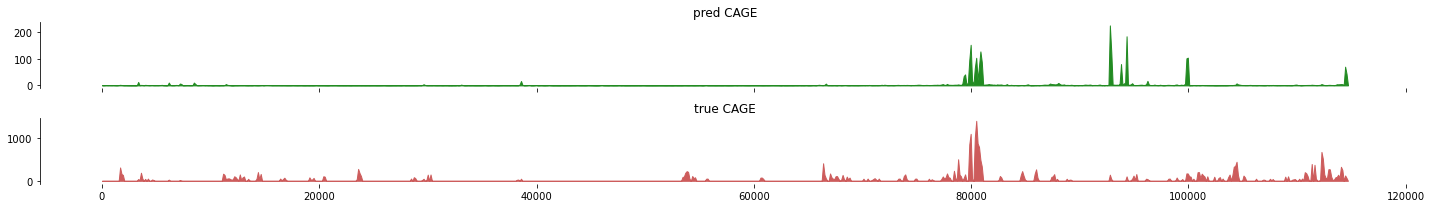

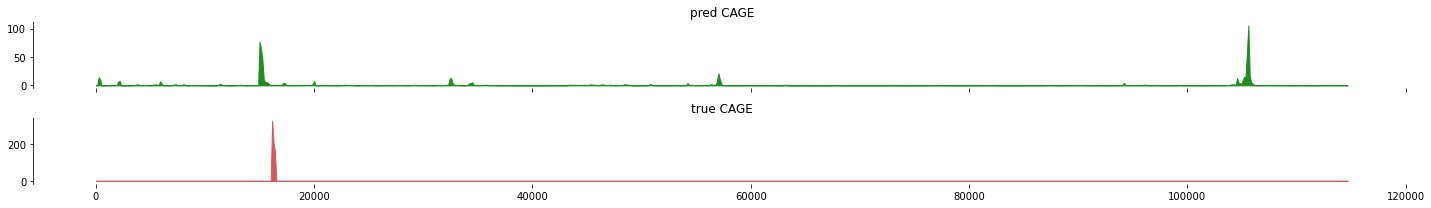

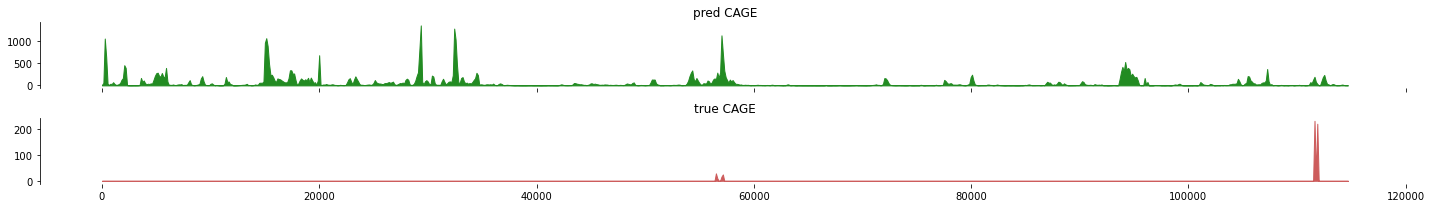

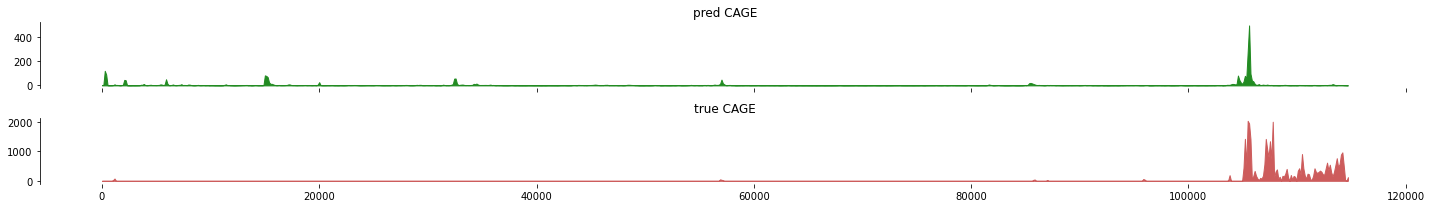

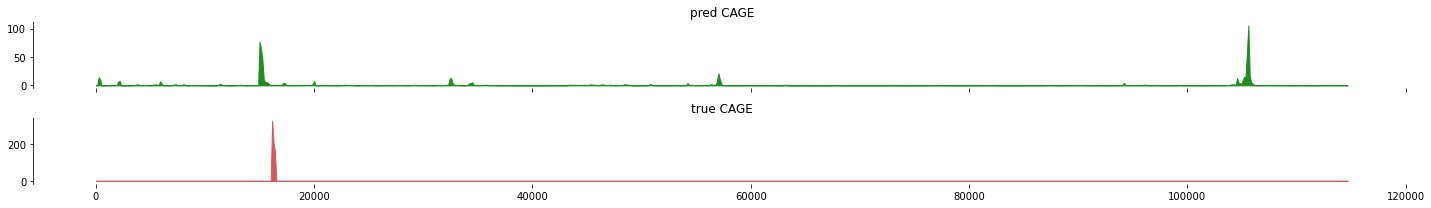

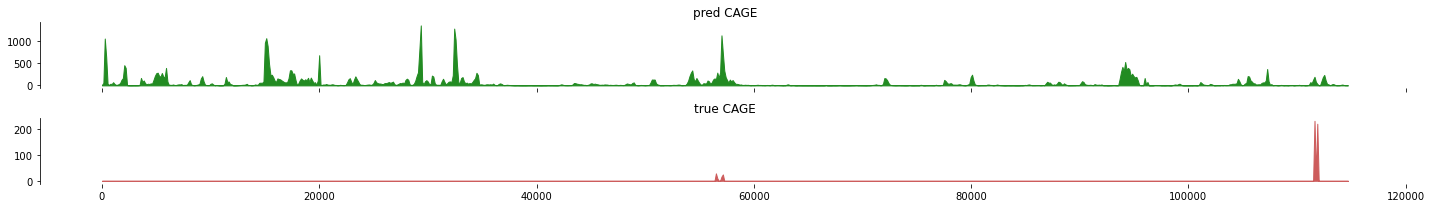

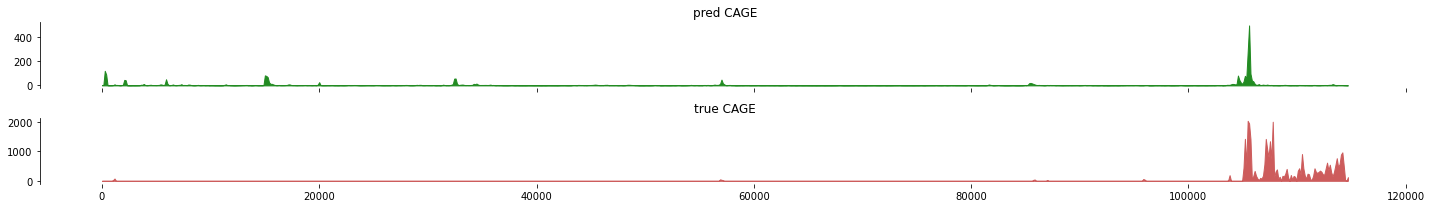

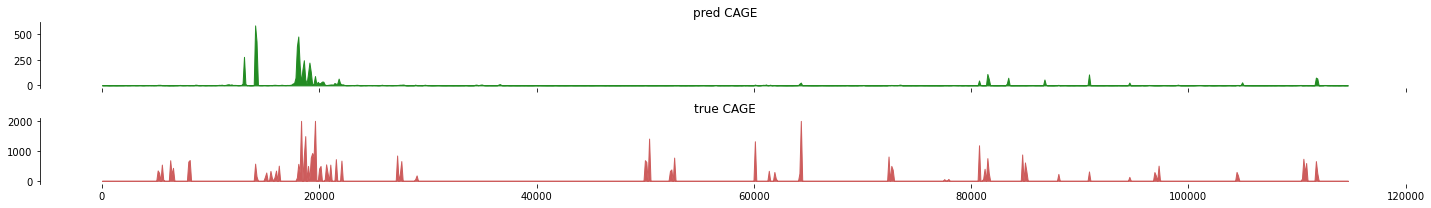

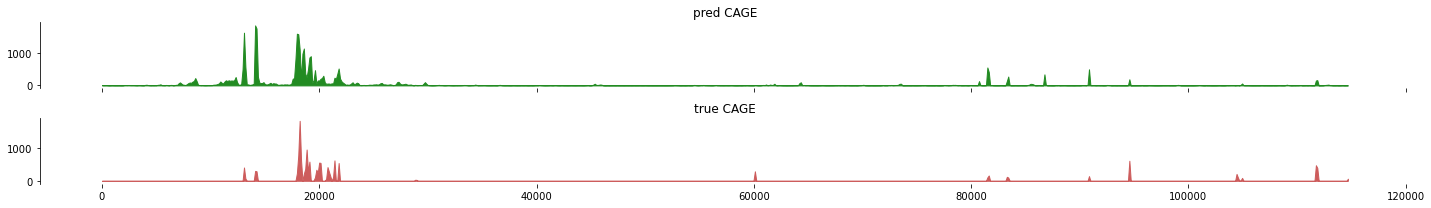

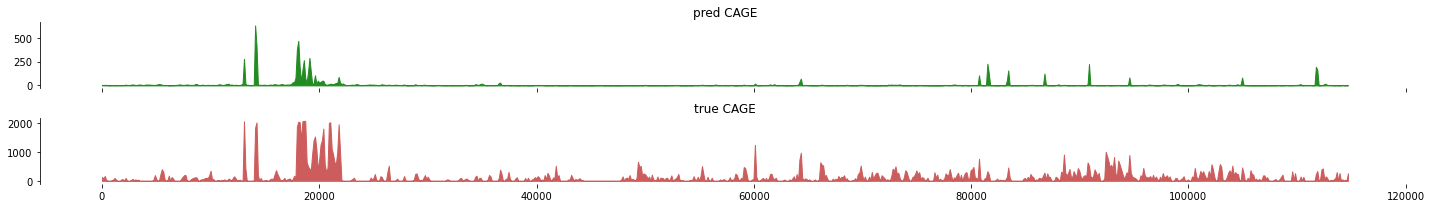

In [28]:
#list_files = (tf.io.gfile.glob("gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv_rpgc_VAL_TSS_example_genes/valid/*ENSG00000000003*.tfr"))
#random.shuffle(list_files)
#files = tf.data.Dataset.list_files(list_files)

def plot_tracks(tracks, start,end, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)

  plt.tight_layout()

#gene_id_ensembl = 'ENSG00000000003'
cell_types = ['HG_A375', 'HG_HT1080', 'HG_THORACIC_AORTA']
        
    
for plot_idx in range(1400,1420):
#for k in range(1000,1010):
    for cell_type in cell_types:
        filename = "gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv_rpgc_VAL_TSS_holdout/valid/" + cell_type  + ".tfr"

        g = tf.random.Generator.from_seed(datetime.now().timestamp())
        dataset = tf.data.TFRecordDataset(filename,
                                          compression_type='ZLIB',
                                          num_parallel_reads=4)
        dataset = dataset.map(lambda record: deserialize_val_TSS(record,
                                                             196608,
                                                             10,
                                                                 49152,
                                                             1536,
                                                             320,
                                                             128,
                                                                True,
                                                                0.10,
                                                                True, True,True,g),
                              deterministic=False,
                              num_parallel_calls=4)
        dataset=dataset.batch(1)
        iter_test = iter(dataset)
        for k in range(2000):
            test = next(iter_test)
            if k == plot_idx:
                inputs = test['sequence'], \
                            test['atac'], \
                                test['global_acc']
                predictions = model(inputs,training=False)

                tracks = {'pred CAGE': (predictions[0,:, 1], 'forestgreen'),
                          'true CAGE': (test['target'][0,:,1], 'indianred')}
                plot_tracks(tracks, 0,114688)
        

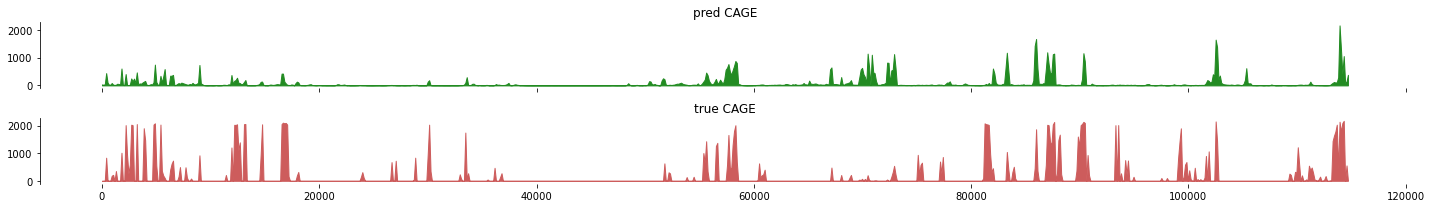

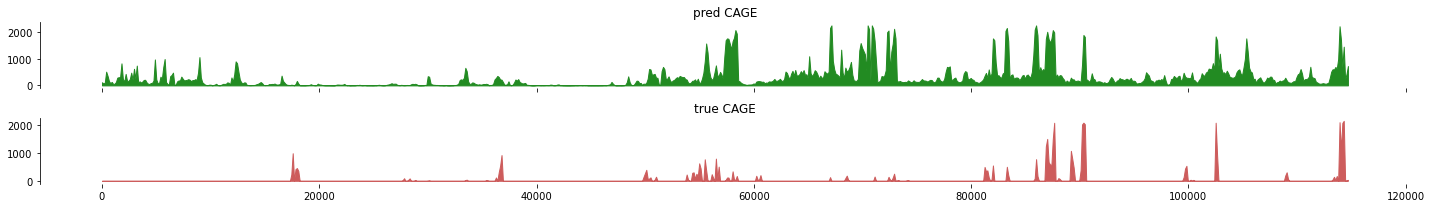

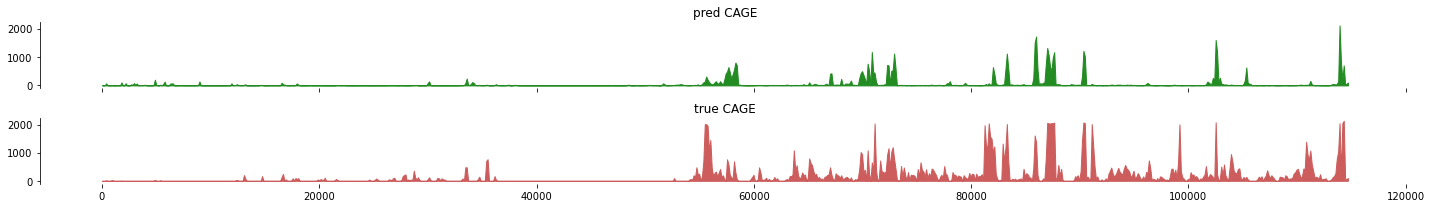

In [27]:
#list_files = (tf.io.gfile.glob("gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv_rpgc_VAL_TSS_example_genes/valid/*ENSG00000000003*.tfr"))
#random.shuffle(list_files)
#files = tf.data.Dataset.list_files(list_files)

def plot_tracks(tracks, start,end, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)

  plt.tight_layout()

#gene_id_ensembl = 'ENSG00000000003'
cell_types = ['HG_A375', 'HG_HT1080', 'HG_THORACIC_AORTA']
            
#for k in range(1000,1010):
for cell_type in cell_types:
    filename = "gs://picard-testing-176520/genformer_atac_rampage_globalacc_conv_rpgc_VAL_TSS_holdout/valid/" + cell_type  + ".tfr"

    g = tf.random.Generator.from_seed(datetime.now().timestamp())
    dataset = tf.data.TFRecordDataset(filename,
                                      compression_type='ZLIB',
                                      num_parallel_reads=4)
    dataset = dataset.map(lambda record: deserialize_val_TSS(record,
                                                         196608,
                                                         10,
                                                             49152,
                                                         1536,
                                                         320,
                                                         128,
                                                            True,
                                                            0.10,
                                                            True, True,True,g),
                          deterministic=False,
                          num_parallel_calls=4)
    dataset=dataset.batch(1)
    iter_test = iter(dataset)
    for k in range(2000):
        test = next(iter_test)
        if k == 1700:
            inputs = test['sequence'], \
                        test['atac'], \
                            test['global_acc']
            predictions = model(inputs,training=False)

            tracks = {'pred CAGE': (predictions[0,:, 1], 'forestgreen'),
                      'true CAGE': (test['target'][0,:,1], 'indianred')}
            plot_tracks(tracks, 0,114688)
        

TypeError: Scalar tensor has no `len()`

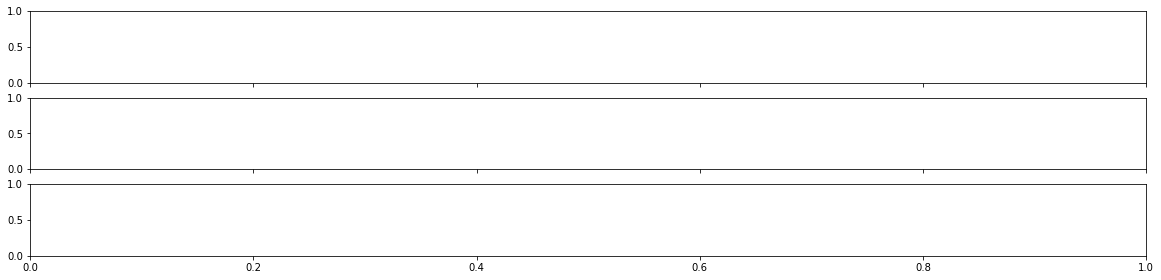

In [6]:
mask_atac = tf.reduce_sum(tf.reshape(test['atac'][0,:,:], [1536,32]),axis=1,keepdims=True)[320:-320,:]
mask_atac.shape
tracks = {'pred ATAC': predictions[0,:, 0],
          'mask ATAC': mask_atac[:,0],
          'true ATAC': test['target'][0,:,0]}
plot_tracks(tracks, 0,114688)

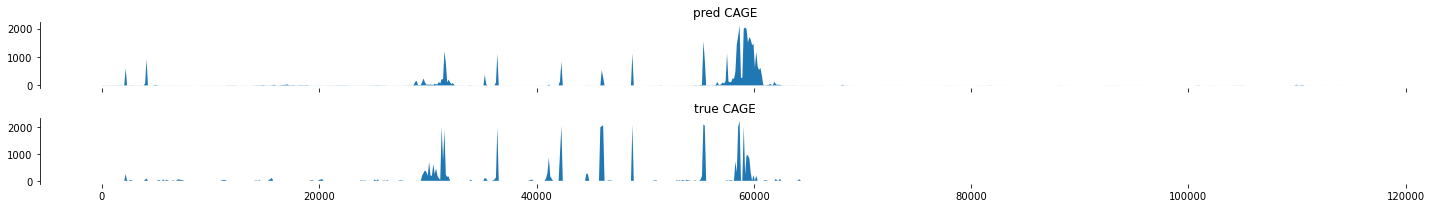

In [76]:
tracks = {'pred CAGE': predictions[0,:, 1],
          'true CAGE': test['target'][0,:,1]}
plot_tracks(tracks, 0,114688)

In [77]:
mask = np.zeros(predictions.shape)
for k in range(predictions.shape[1]):
    if k in [447,448,449]:
        mask[:,k,1]=1
myc_scores = contribution_input_grad(model,inputs,mask)

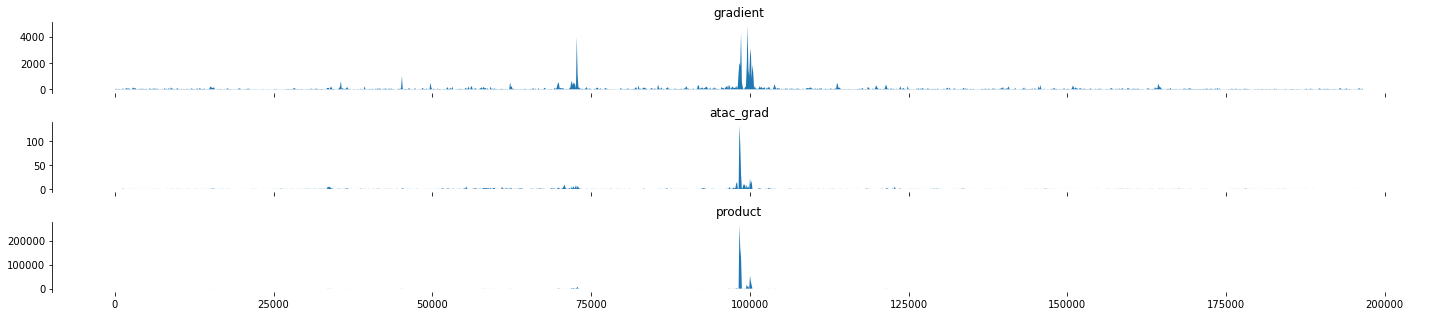

In [81]:
seq_grads, atac_grads, tf_acc_grads, prediction,att_matrices = myc_scores

seq_grad = tf.math.abs(tf.reduce_sum(tf.reshape(seq_grads, [1536,128]),axis=1))
atac_grad = tf.math.abs(tf.reduce_sum(tf.reshape(atac_grads,[1536,32]),axis=1))
tracks={'gradient': seq_grad,
        'atac_grad': atac_grad,
        'product': (seq_grad*atac_grad)}

plot_tracks(tracks, 0,114688)

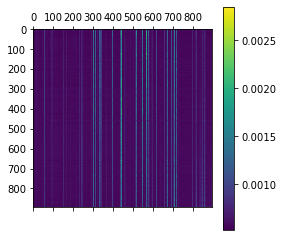

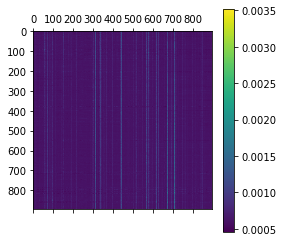

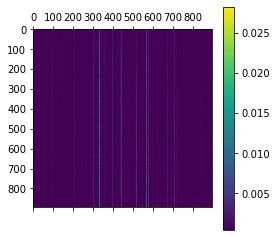

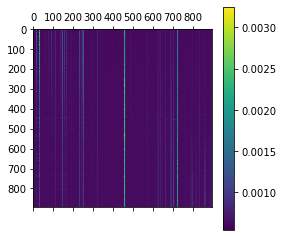

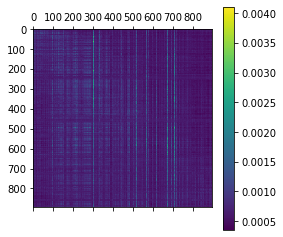

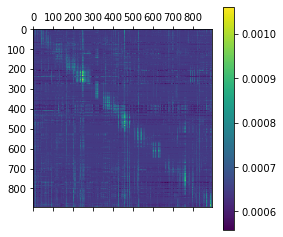

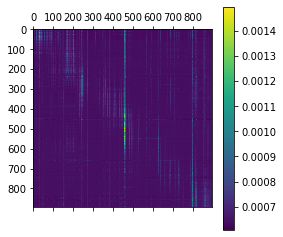

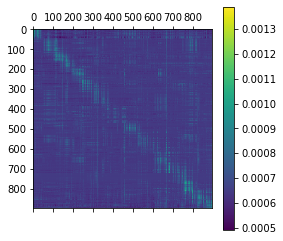

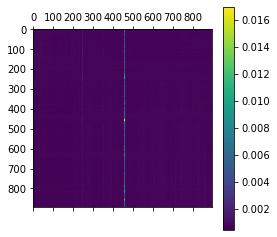

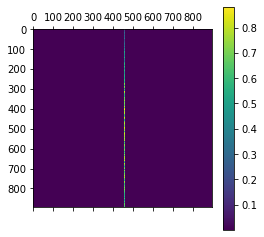

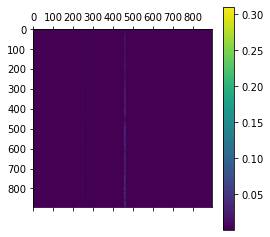

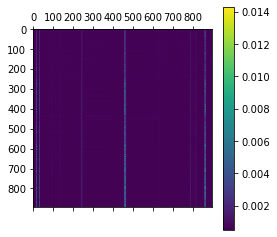

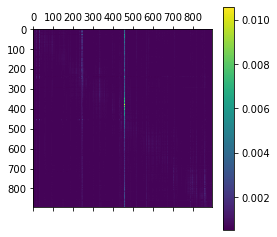

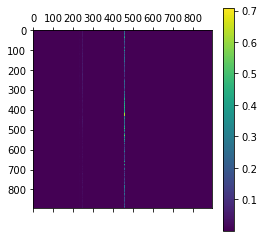

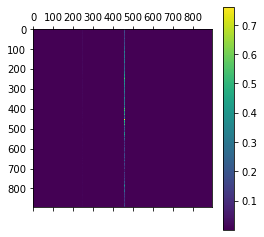

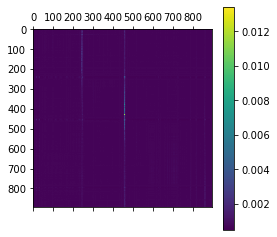

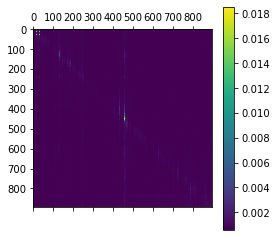

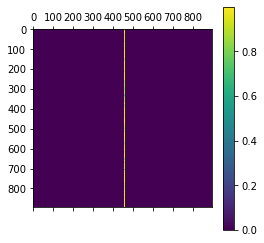

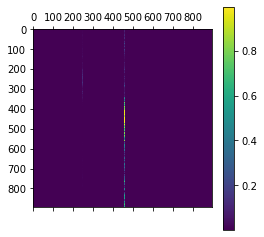

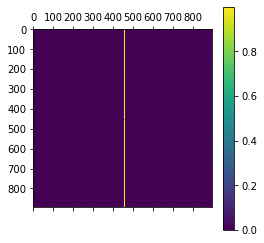

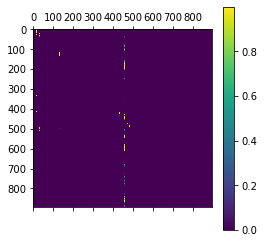

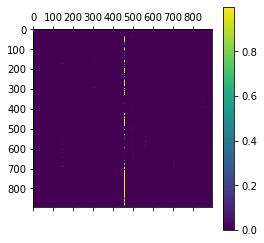

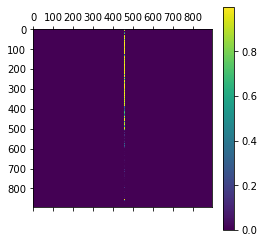

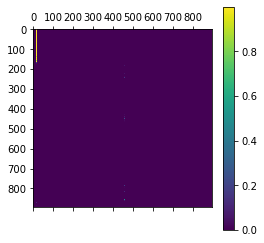

In [79]:
for idx in range(6):
    k_1,q_1 = att_matrices['layer_' + str(idx)]
    mat_unstim = []
    promoter_att_unstim=[]
    for i in range(0,4):
        temp = tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(432.0))
        temp = temp[320:-320,320:-320]
        mat_unstim.append(temp)
        plt.matshow(temp)
        plt.colorbar()
        plt.show()
        temp_prom = tf.reduce_sum(temp[254:258,:],axis=0)
        promoter_att_unstim.append(temp_prom)

In [80]:
tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])))

<tf.Tensor: shape=(1536, 1536), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
list_files